# Gradient Boosting - Heart Disease Classification
Part 2 of the course project in *Artificial intelligence applied to engineering* at ETSEIB, UPC, spring 2024. The team members contributing to the deliverable is 
- Lise Jakobsen
- Julie Sørlie Lund
- Magnus Ingnes Sagmo

The dataset used in this deliverable can be retrieved from [Kaggle](https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset).

## Data set review

#### Target class
The target class, `HeartDisease`, is a boolean class telling whether the patient has a heart disease. Subsequently, this is a classification problem.

#### Features
The data set has 11 features. Two of these, `ChestPainType` and `RestingECG`, are one-hot encoded. 

#### Preprocessing method
Before applying Gradient Boosting
- zero values of `Cholesterol` are imputed using `sklearn.impute.KNNImputer`.
- the data is split into train and test set using `sklearn.model_selection.train_test_split`.
- the data is normalized using `sklearn.preprocessing.StandardScaler`.

In addition, we will try to both keep and remove outliers to see what produces best predictions. 

## Performance metrics

#### Recall
In the case of detecting heart diseases it is crucial to minimize the number of false negatives (people with a heart disease going unnoticed). We will therefore focus on minimizing recall.

#### F1-score
By solely focusing on recall, we can end with a too high number of false positives (by choosing a model that classifies everything as heart disease). We will therefore also look at the F1-score, as it offers a balance between precision and recall. 

#### Precision-recall curve
The precision-recall curve is a good way to visualize how well the model balances precision and recall. 

#### Confusion matrix
A good way to look at the number of false positives is looking at the confusion matrix. This will allow us to simultaneously look at false negatives, true positives and true negatives. 


## Hyperparameters

We chose to focus the grid search on a subset of hyperparameters: learning_rate, max_depth, and n_estimators. The primary reasons for this focused approach are computational efficiency and the significant impact these parameters have on model performance.

#### Learning rate
Controls the rate at which the boosting algorithm learns from its mistakes. It is usually set to a lower value (between 0.001 to 0.01) to allow the algorithm to more gradually compensate for its mistakes. Lower values usually result in a model that takes longer to train, but generalizes better to new data. This hyperparameter is crucial because it directly affects the model’s ability to learn and generalize. 

#### Maximum depth of trees
Sets the maximum depth of each tree. The depth controls the complexity of individual trees. Large values allows for more complex trees, but also increases the risk of overfitting. This hyperparameter is essential for balancing bias and variance, influencing the model’s ability to capture intricate patterns without overfitting.

#### Number of trees
Use cross-validation to find optimal number. To find the optimum level we can plot the training and validation error or accuracy scores for every iteration and observe when the validation error begin to rise. Or we can set the number of trees to a large value, and introduce an early stopping criteria on which to terminate training. More trees generally improve performance but also increase the risk of overfitting and computational cost. It’s a key parameter that interacts with the learning rate; a higher number of estimators with a lower learning rate can lead to better performance.

### Reasons for Not Including Other Hyperparameters

#### Min_samples_split and min_samples_leaf
These parameters help prevent overfitting by specifying the minimum number of samples required to split an internal node and to be at a leaf node, respectively. While important, they have a more nuanced effect compared to the primary parameters selected. 

#### Max_features
Controls the number of features considered for splitting a node. While it can help in reducing overfitting by decorrelating trees, it is often less impactful than learning rate, max depth, and number of estimators.

#### Subsamples
Determines the fraction of samples used for fitting individual base learners. It helps in stochastic gradient boosting but is typically fine-tuned after the primary parameters.

#### Subsample ratio
Sets the fraction of the training data that is used to train each tree. A lower value can help reduce overfitting. Ranges from (0,1]

### Load data

We will split the data in training and test set, and only use the train data for the cross validation in the grid search. This will reduce the amount of data used to train the models and tuning hyperparameters, butt will ensure no data leakage and help reduce overfitting of the model. 

In [2]:
%load_ext autoreload
%autoreload 2

from preprocessor import Preprocessor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, f1_score, precision_recall_curve, auc, precision_score
import numpy as np
import pandas as pd
from sklearn.model_selection import validation_curve

In [3]:
prep = Preprocessor()

X_train, X_test, y_train, y_test = prep.get_data(test_size=0.25, impute_method='gb', remove_outliers=True, scaling_method='standard')

### Set up hyperparameters grid

We will explore
- `learning_rate`: Controls the rate at which the model learns from its mistakes.Range: [0.001, 0.01, 0.05, 0.1, 0.2].
- `max_depth`: Range: [3, 4, 5, 6]
- `n_estimators`: More trees can improve accuracy but also increase the risk of overfitting. We aim to find a balance that offers the best generalization performance. Range: [50, 100, 150, 200]

In [4]:
# Define the parameter grid
param_grid = {
    'learning_rate': [0.001, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 8],
    'n_estimators': [50, 100, 150],
}

### Perform grid search

As stated above, we will focus mainly on recall and F1-score for our model evaluation. For the grid search we will use F1-score as evaluation metric, because
- using recall can cause an unacceptably poor precision.
- F1-score also considers true positives.

To narrow the number of combinations we will further evaluate, we retrieve the six best combinations from the grid search.

In [5]:
# Define model

gb = GradientBoostingClassifier()

# Perform grid search
grid_search = GridSearchCV(gb, param_grid, cv=5, scoring='f1', return_train_score=True, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Extract the six best iterations, based on mean F1 score
results = pd.DataFrame(grid_search.cv_results_)
top_6 = results.nlargest(6, 'mean_test_score')  
# Extract only the interesting columns from the DataFrame
top_6 = top_6[['param_learning_rate', 'param_max_depth', 'param_n_estimators', 'mean_test_score', 'std_test_score']]

top_6

,param_learning_rate,param_max_depth,param_n_estimators,mean_test_score,std_test_score
29,0.2,3,150,0.875918,0.034866
9,0.05,3,50,0.873277,0.025783
31,0.2,5,100,0.872064,0.033765
10,0.05,3,100,0.871181,0.028033
23,0.1,5,150,0.869210,0.023856
18,0.1,3,50,0.868673,0.021322


The six best combinations using the F1-score are:

- Learning rates range between 0.05 and 0.2.
- Max depths are either 3 or 5.
- Number of estimators is spread across 50, 100, and 150.

The combination of hyperparameters with the highest mean F1 score from the grid search uses `learning_rate=0.2`, `max_depth=5` and `n_estimators=50`.

Having a higher learning rate (0.2) and a moderate maximum depth (5) with fewer estimators (50) as the top performer indicates that the model benefits from learning quickly and capturing moderately complex patterns without overfitting. 

### Evaluating top 6 combinations
We will continue by examining how these six top results perform on unseen data. We will look at 
- F1-score
- Recall
- Precision
- Precision-Recall Area Under Curve

In [6]:
# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    # Make prediction
    y_pred = model.predict(X_test)

    # Retrieve scores
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
    pr_auc = auc(recall_curve, precision_curve)

    return recall, f1, precision, pr_auc

In [7]:
# DataFrame with evaluation metric for each of the top 6 models
evaluation_results = pd.DataFrame(columns=['learning_rate', 'max_depth', 'n_estimators' ,  'Recall', 'F1-score', 'Precision', 'Precision-recall AUC'])

# Iterate the top 6 parameter combinations
for (index, row) in top_6.iterrows():

    # Dict with params from the row
    params = {
        'learning_rate': row['param_learning_rate'],
        'max_depth': row['param_max_depth'],
        'n_estimators': int(row['param_n_estimators'])
    }

    # Fit the model with params
    model = GradientBoostingClassifier(learning_rate=params['learning_rate'], max_depth=params['max_depth'], n_estimators=params['n_estimators'])
    model.fit(X_train, y_train)
    
    # Evaluate the model
    recall, f1, precision, pr_auc = evaluate_model(model, X_test, y_test)

    new_row = {
        'learning_rate': params['learning_rate'],
        'max_depth': params['max_depth'],
        'n_estimators': params['n_estimators'],
        'Recall': round(recall, 3), 
        'Precision': round(precision, 3), 
        'F1-score': round(f1, 3), 
        'Precision-recall AUC': round(pr_auc, 3)
    }
    evaluation_results.loc[len(evaluation_results)] = new_row

evaluation_results = evaluation_results.sort_values(by=['Recall', 'F1-score'])
evaluation_results

,learning_rate,max_depth,n_estimators,Recall,F1-score,Precision,Precision-recall AUC
2,0.20,5,100,0.827,0.870,0.917,0.927
4,0.10,5,150,0.835,0.874,0.917,0.933
0,0.20,3,150,0.850,0.873,0.897,0.942
1,0.05,3,50,0.857,0.874,0.891,0.955
3,0.05,3,100,0.857,0.887,0.919,0.952
5,0.10,3,50,0.857,0.887,0.919,0.954


- The model with learning_rate=0.05, max_depth=3, and n_estimators=100 has the highest F1-score (0.887) and good recall (0.857), precision (0.919), and Precision-recall AUC (0.952).
- The model with learning_rate=0.05, max_depth=3, and n_estimators=50 has the same recall (0.857) and F1-score (0.874) as the model with n_estimators=100, but with fewer estimators, making it computationally less expensive.
  
From the results on the unseen data, we will further evaluate a model using learning_rate=0.05, max_depth=3, and n_estimators=100. This is due to the following considerations:
  
- The recall rate is equal to the top performers and ensures that most true positives are captured.
- The F1-score is high and very close to the best performing models.
- The increase in computational expenditure going from 50 to 100 estimators is negligible, so we prefer the latter.

### Bias and variance

Next, we examine the model performance in the context of bias and variance by plotting a validation curve.

In [12]:
def plot_validation_curve(param_name, param_range):

    best_params = {'learning_rate':0.05, 'max_depth':3, 'n_estimators':100}
    del best_params[param_name]

    # Calculate scores for validation curve
    train_scores, test_scores = validation_curve(
        GradientBoostingClassifier(random_state=42, **best_params),
        X_train, y_train, param_name=param_name, 
        param_range=param_range,
        cv=5, scoring="recall", n_jobs=-1)

    # Calculate mean and standard deviation for train and test scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the validation curve
    plt.figure(figsize=(6, 3))
    plt.plot(param_range, train_mean, label="Training score", color="r")
    plt.plot(param_range, test_mean, label="Cross-validation score", color="g")

    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="g", alpha=0.1)

    plt.title("Validation Curve for Gradient Boosting")
    plt.xlabel(f"{param_name}")
    plt.ylabel("Recall")
    plt.legend(loc="best")
    plt.show()

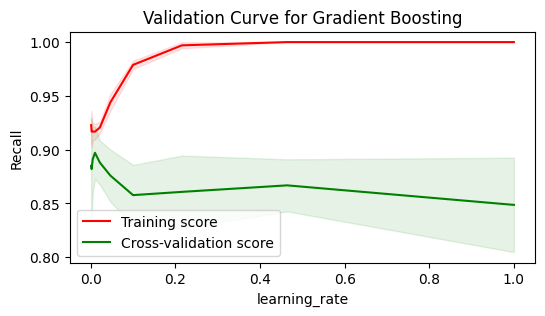

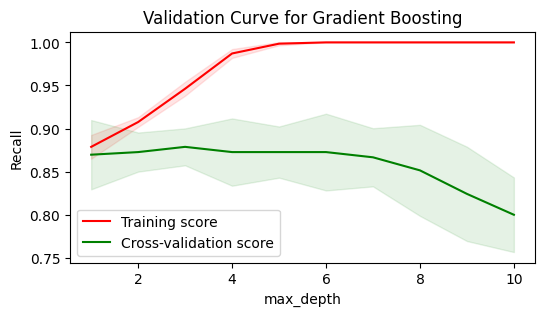

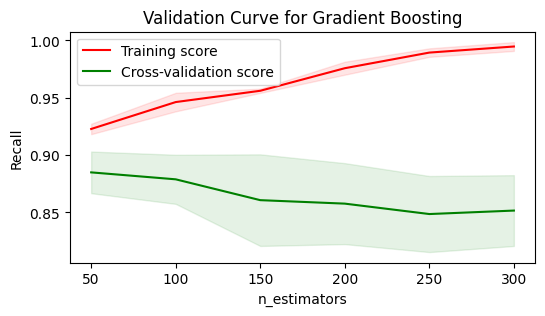

In [13]:
learning_rate_range = np.logspace(-3, 0, 10)
max_depth_range = np.arange(1, 11)
n_estimators_range = np.arange(50, 301, 50)

# Plot validation curves
plot_validation_curve('learning_rate', learning_rate_range)
plot_validation_curve('max_depth', max_depth_range)
plot_validation_curve('n_estimators', n_estimators_range)

### Learning rate

The training score starts high and continues to approach 100% as the learning_rate increases. This indicates that the model is becoming more complex and able to fit the training data very well.
The cross-validation score peaks at a learning_rate of around 0.05, and then starts to decrease. This suggests that for higher learning rates, the model starts to overfit the training data, resulting in poorer generalization to unseen data.

A learning_rate around 0.05 seems optimal. Higher learning rates lead to overfitting, as evidenced by the drop in cross-validation scores, indicating high variance.

### Max depth

The training score increases as max_depth increases, reaching nearly 100% for higher values of max_depth. This is expected, as deeper trees can capture more complex patterns in the training data.

The cross-validation score has a slight peak at max_depth of 3, then starts to decline. This indicates that deeper trees are overfitting the training data, as they do not generalize well to the validation data.

A max_depth of 3 appears optimal. Increasing max_depth beyond this value leads to overfitting, as evidenced by the declining cross-validation scores, indicating high variance.

### Number of estimators

The training score increases with the number of estimators, approaching 100% as n_estimators increases. This indicates that more trees allow the model to better fit the training data.

The cross-validation score remains relatively stable, but with a slight decrease as n_estimators increases. This suggests that while the model complexity increases with more estimators, it does not significantly improve the generalization and might lead to slight overfitting.

Using around 50 to 100 estimators seems sufficient. Increasing n_estimators beyond this point does not significantly improve the cross-validation score and may slightly contribute to overfitting, indicating high variance.
